## VISUALIZING MODELS, DATA, AND TRAINING WITH TENSORBOARD
In this tutorial, we’ll learn how to:
- Read in data and with appropriate transforms (nearly identical to the prior tutorial).
- Set up TensorBoard.
- Write to TensorBoard.
- Inspect a model architecture using TensorBoard.
- Use TensorBoard to create interactive versions of the visualizations we created in last tutorial, with less code.

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

dataPath='/media/zhang/Disk0/dataset/d2l/data'

# transforms
transform=transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,),(0.5,))]
)

# datasets
trainset=torchvision.datasets.FashionMNIST(
    dataPath,
    download=False,
    train=True,
    transform=transform
)

testset=torchvision.datasets.FashionMNIST(
    dataPath,
    download=False,
    train=False,
    transform=transform
)

# dataloads
trainloader=torch.utils.data.DataLoader(
    trainset,
    batch_size=4,
    shuffle=True,
    num_workers=4
)
testloader=torch.utils.data.DataLoader(
    testset,
    batch_size=4,
    shuffle=True,
    num_workers=4
)

# constant for classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# helper function to show an image
def matplotlib_imshow(img,one_channel=False):
    if one_channel:
        img=img.mean(dim=0)
    img=img/2+0.5  # unnormalize
    npimg=img.numpy()
    if one_channel:
        plt.imshow(npimg,cmap='Greys')
    else:
        plt.imshow(np.transpose(npimg,(1,2,0)))

In [2]:
"""
define model
"""
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1=nn.Conv2d(1,6,5)
        self.pool=nn.MaxPool2d(2,2)
        self.conv2=nn.Conv2d(6,16,5)
        self.fc1=nn.Linear(16*4*4,120)
        self.fc2=nn.Linear(120,84)
        self.fc3=nn.Linear(84,10)

    # 前向传播过程
    def forward(self,x):
        x=self.pool(F.relu(self.conv1(x)))
        x=self.pool(F.relu(self.conv2(x)))
        x=x.view(-1,16*4*4)  # 将x调整为16*4*4列的形状
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=self.fc3(x)
        return x

net=Net()

In [3]:
"""
define optimizer and criterion
"""
criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(net.parameters(),lr=0.001,momentum=0.9)

### 1.TensorBoard setup

In [4]:
"""
TensorBoard setup
"""
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer=SummaryWriter('./runs/fashion_mnist_experiment_1')

In [8]:
type(trainloader)

torch.utils.data.dataloader.DataLoader

### 2.Writing to TensorBoard

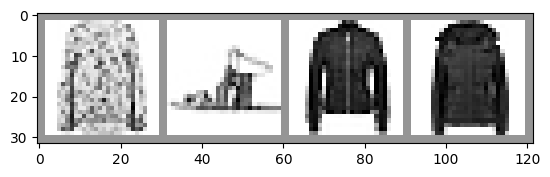

In [5]:
"""
 let’s write an image to our TensorBoard - specifically, a grid - using `make_grid`.
"""
# get some random training images
dataiter=iter(trainloader)
images,labels=next(dataiter)

# create grid of images
img_grid=torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid,one_channel=True)

# write to tensorboard
writer.add_image('four_fashion_mnist_images',img_grid)

#!tensorboard --logdir=runs

### 3.Inspect the model using TensorBoard

In [6]:
"""
visualize complex model structures.
"""
writer.add_graph(net,images)
writer.close()

### 4.Adding a “Projector” to TensorBoard

In [7]:
"""
visualize the lower dimensional representation of higher dimensional data via the `add_embedding` method
"""
# helper function
def select_n_random(data,labels,n=100):
    """
    Selects n random datapoints and their corresponding labels from a dataset
    """
    assert len(data) == len(labels)
    perm=torch.randperm(len(data))  # Returns a random permutation of integers from ``0`` to ``n - 1``.
    return data[perm][:n],labels[perm][:n]

# elect random images and their target indices
images,labels=select_n_random(trainset.data,trainset.targets)

# get the class labels for each image
class_labels=[classes[lab] for lab in labels]

# log embeddings
features=images.view(-1,28*28)

writer.add_embedding(
    features,
    metadata=class_labels,
    label_img=images.unsqueeze(1)
)
writer.close()

### 5.Tracking model training with TensorBoard

In [8]:
"""
printed the model’s running loss every 2000 iterations
- along with a view into the predictions the model is making via the `plot_classes_preds` function.
"""
# helper functions

def image_to_probs(net,images):
    """
    Generates predictions and corresponding probabilities from a trained network and a list of images
    """
    output=net(images)
    # convert output probabilities to predicted class
    _,pred_tensor=torch.max(output,1)
    preds=np.squeeze(pred_tensor.numpy())
    return preds,[F.softmax(el,dim=0)[i] for i,el in zip(preds,output)]

def plot_classes_preds(net,images,labels):
    """
    Generates matplotlib Figure using a trained network, along with images and labels from a batch, that shows the network's top prediction along with its probability, alongside the actual label, coloring this information based on whether the prediction was correct or not.

    Uses the "images_to_probs" function.
    """
    preds,probs=image_to_probs(net,images)
    # plot the image in the batch,along with predicted and true labels
    fig=plt.figure(figsize=(12,48))
    for idx in np.arange(4):
        ax=fig.add_subplot(1,4,idx+1,xticks=[],yticks=[])
        matplotlib_imshow(images[idx],one_channel=True)
        ax.set_title("{0},{1:.1f}% \n (label: {2})".format(
            classes[preds[idx]],
            probs[idx]*100.0,
            classes[labels[idx]]
        ),color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

"""
train the model and write results to TensorBoard every 1000 batches
"""
running_loss=0.0
for epoch in range(1):  # loop over the dataset multiple times

    for i,data in enumerate(trainloader,0):
        # get the inputs; data is a list of [inputs, labels]
        inputs,labels=data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs=net(inputs)
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i%1000 == 999:  # every 1000 mini_batches
            # ...log the running loss
            writer.add_scalar(
                'training loss',
                running_loss/1000,
                epoch * len(trainloader)+i
            )
            # ...log a Matplotlib Figure showing the model's predictions on a random mini-batch
            writer.add_figure('predictions vs. actuals',
                              plot_classes_preds(net,inputs,labels),
                              global_step=epoch*len(trainloader)+i)
            running_loss=0.0
print('Finished Training')

Finished Training


### 6.Assessing trained models with TensorBoard

In [9]:
"""
You will now see a “PR Curves” tab that contains the precision-recall curves for each class.
"""
# 1. gets the probability predictions in a test_size x num_classes Tensor
# 2. gets the preds in a test_size Tensor
# takes ~10 seconds to run
class_probs = []
class_label = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        output = net(images)
        class_probs_batch = [F.softmax(el, dim=0) for el in output]

        class_probs.append(class_probs_batch)
        class_label.append(labels)

test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
test_label = torch.cat(class_label)

# helper function
def add_pr_curve_tensorboard(class_index, test_probs, test_label, global_step=0):
    '''
    Takes in a "class_index" from 0 to 9 and plots the corresponding
    precision-recall curve
    '''
    tensorboard_truth = test_label == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(classes[class_index],
                        tensorboard_truth,
                        tensorboard_probs,
                        global_step=global_step)
    writer.close()

# plot all the pr curves
for i in range(len(classes)):
    add_pr_curve_tensorboard(i, test_probs, test_label)